In [1]:
import os, sys
sys.path.insert(0, os.getcwd()) # Make this dir the priority

In [2]:
import json
from torch_geometric.loader import DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
import torch
import numpy as np
from test_from_studies import gen_args_from_optuna_params
from config import Dataset, Embedder
from model import build_model
from dataset import get_dataset

/home/jsimonrichard/QML_Research/QFE-Experiments/qfe_exp_venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
results = json.load(open("study_outputs/dataset-PROTEINS/results.json"))

In [4]:
# Finding the best QFE-exp model
qfe_exp_max = max(results["accuracies"]["QFE-exp"]["best_all"])
qfe_exp_fold = results["accuracies"]["QFE-exp"]["best_all"].index(qfe_exp_max)
print(f"QFE-exp max accuracy (at fold {qfe_exp_fold}): {qfe_exp_max}")

QFE-exp max accuracy (at fold 3): 0.7522522522522522


In [5]:
qfe_exp_data = results["best_trials"]["QFE-exp"]["best_all"][qfe_exp_fold]
print(json.dumps(qfe_exp_data, indent=4))

{
    "number": 153,
    "validation_results": [
        0.714214424706547,
        0.012751867428284491,
        91610.0
    ],
    "params": {
        "pooling": "max",
        "model": "GCN",
        "qfe_layers": 2,
        "layers": 11,
        "hidden": 100,
        "dropout": 0.021612240458739662,
        "lr": 0.0003028347804333664,
        "weight_decay": 6.876110686678228e-05
    }
}


In [6]:
# Get dataset (with the correct fold)
ds = get_dataset(Dataset.PROTEINS)

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_index, test_index = list(folds.split(ds, ds.y))[qfe_exp_fold]
train_ds, test_ds = ds[train_index], ds[test_index]

In [7]:
# Build model
args = gen_args_from_optuna_params(Dataset.PROTEINS, Embedder.QFE_EXP, qfe_exp_data["params"])

model = build_model(args, train_ds.num_features, train_ds.num_classes)

QFE_exp_exp_key = results["exps"]["QFE-exp"]["best_all"][qfe_exp_fold]
checkpoint_path = f"./checkpoints/{QFE_exp_exp_key}/fold-0-model.pth" # Since each fold has its own experiment the fold number here is 0
model_checkpoint = torch.load(checkpoint_path)
model.load_state_dict(model_checkpoint["model_state_dict"])

<All keys matched successfully>

In [8]:
embeddings = model.embedder(test_ds.x).detach().numpy()
embeddings.shape

(8498, 4)

In [9]:
import matplotlib.pyplot as plt

In [10]:
# PCA for visualization
pca = PCA(n_components=2)

pca_embeddings = pca.fit_transform(embeddings)
pca_no_embbedder = pca.fit_transform(test_ds.x)

## PCA Based on Node Structure Type

In [11]:
colormap = np.array(['r', 'g', 'b'])
# Get the structure type of each node
structure_type = torch.argmax(test_ds.x[:,1:], dim=1)
structure_categories = structure_type.unique()
structure_categories

tensor([0, 1, 2])

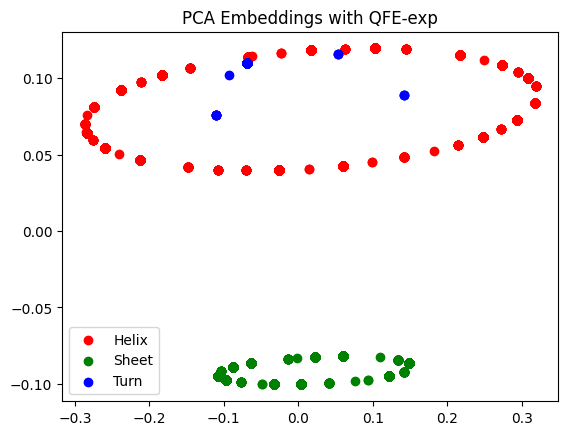

In [12]:
structure_names = ["Helix", "Sheet", "Turn"]
for st in structure_categories:
    points = pca_embeddings[structure_type == st]
    plt.scatter(points[:,0], points[:,1], c=colormap[st], label=structure_names[st])
plt.legend()
plt.title("PCA Embeddings with QFE-exp")
plt.show()

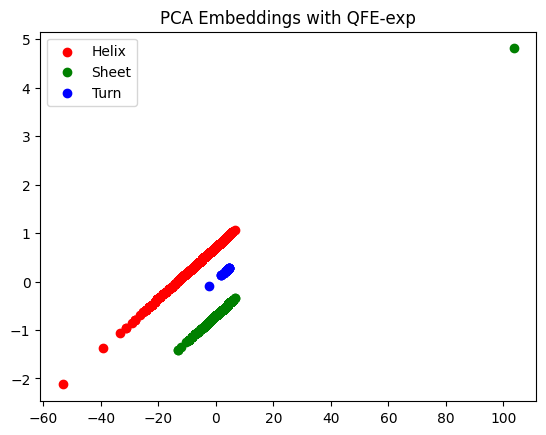

In [13]:
structure_names = ["Helix", "Sheet", "Turn"]
for st in structure_categories:
    points = pca_no_embbedder[structure_type == st]
    plt.scatter(points[:,0], points[:,1], c=colormap[st], label=structure_names[st])
plt.legend()
plt.title("PCA Embeddings with QFE-exp")
plt.show()

## PCA Based on Graph Classication

In [14]:
batch = next(iter(DataLoader(test_ds, batch_size=len(test_ds)))).batch
classes = test_ds.y[batch]
class_types = np.unique(classes)

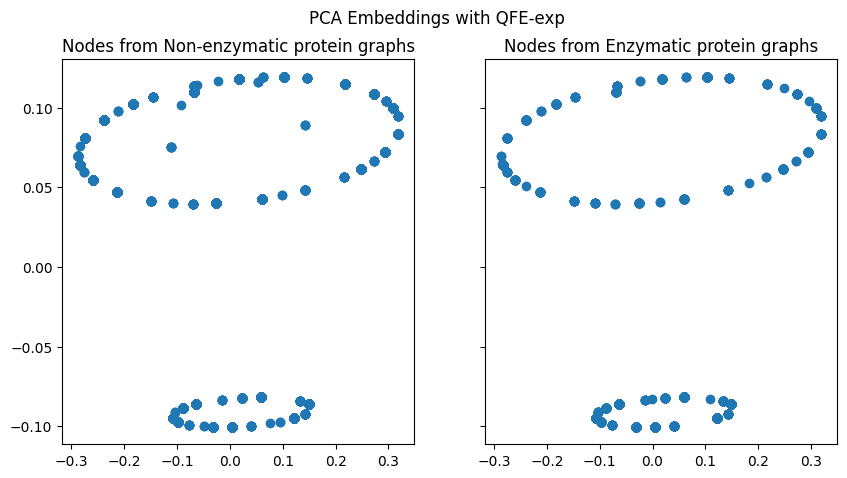

In [15]:
label = ["Non-enzymatic", "Enzymatic"]

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))
fig.suptitle("PCA Embeddings with QFE-exp")

for class_type in class_types:
    data = pca_embeddings[classes == class_type]
    ax[class_type].scatter(data[:, 0], data[:, 1])
    ax[class_type].set_title(f"Nodes from {label[class_type]} protein graphs")
plt.show()

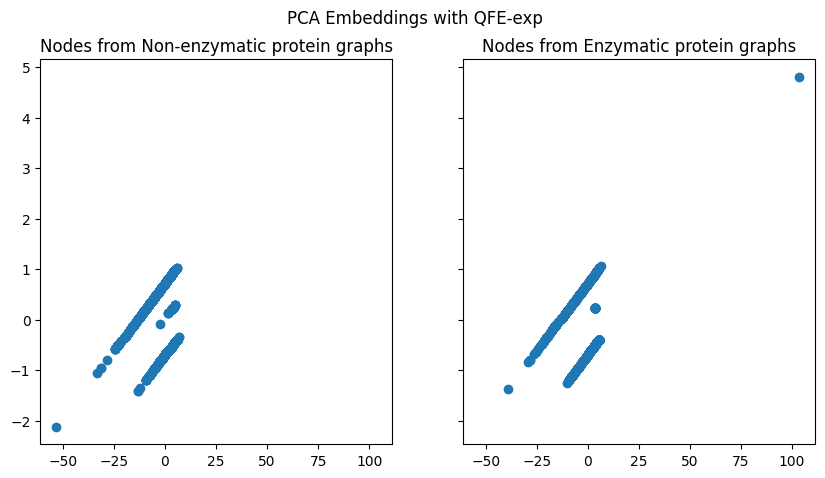

In [16]:
label = ["Non-enzymatic", "Enzymatic"]

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))
fig.suptitle("PCA Embeddings with QFE-exp")

for class_type in class_types:
    data = pca_no_embbedder[classes == class_type]
    ax[class_type].scatter(data[:, 0], data[:, 1])
    ax[class_type].set_title(f"Nodes from {label[class_type]} protein graphs")
plt.show()

## Additional Node Attribute Analysis

In [17]:
structure_categories

tensor([0, 1, 2])

/tmp/ipykernel_130191/1024930970.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


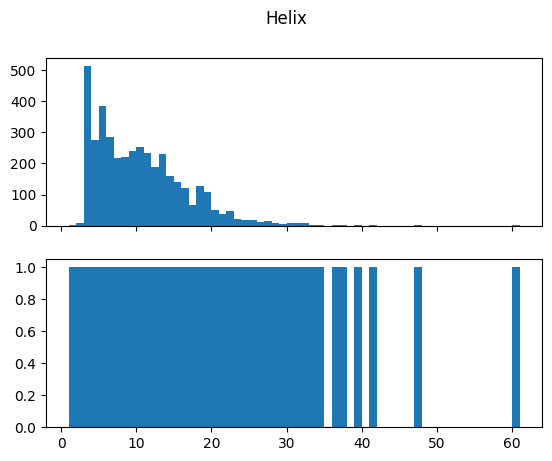

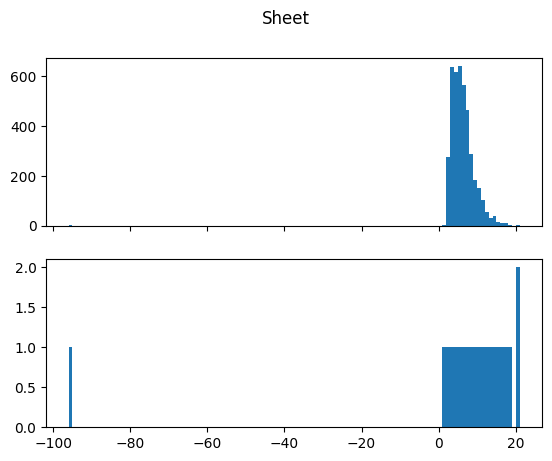

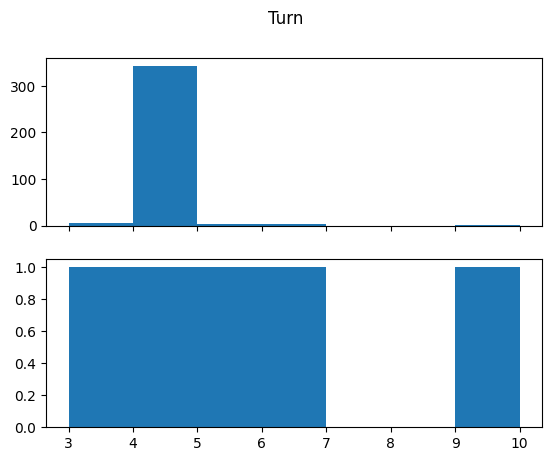

In [26]:
for structure in structure_categories:
    data = test_ds.x[test_ds.x[:, structure+1] == 1][:, 0]
    fig, (ax1, ax2) = plt.subplots(2, sharex=True)
    bins = int(data.max() - data.min())
    ax1.hist(data, bins=bins)
    ax2.hist(data.unique(), bins=bins)
    fig.suptitle(structure_names[structure]) 
    fig.show()